# GAN for Faces

Generative Adversarial Network (GAN) for generating human faces using Deep Learning (Neural Networks) with Tensorflow.

A generative adversarial network (GAN) is a machine learning (ML) model in which two neural networks compete with each other to become more accurate in their predictions. GANs typically run unsupervised and use a cooperative zero-sum game framework to learn.

The two neural networks that make up a GAN are referred to as the generator and the discriminator. The goal of the generator is to artificially manufacture outputs that could easily be mistaken for real data. The goal of the discriminator is to identify which outputs it receives have been artificially created.

## About

[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset was used for this project.

## Environment

I've specified my computer specifications as follows that I used for this project:

* Windows 10 64-bit
* Python 3.6.8
* NVIDIA GTX 1050 Ti 4GB GPU
* CUDA and CuDNN 
* 8 GB RAM
* Tensorflow 1.15.0 GPU Version
* Jupyter Notebook
* Sublime Text

## Necessary Imports

Import the required libraries that would help us achieve our goal. To install required libraries, refer repository's README file and requirements.txt

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from scipy.misc import pilutil as sp
from glob import glob
from datetime import datetime
%matplotlib inline

## Util Functions

Few functions that does the job when called.

**Standard Scaler:** The values in dataset might be anywhere from 0 to infinity. The more data near 1000's or 10000's or millions and less data near 0, is gonna cause bias during training and wouldn't perform well on input values that are closer to 0.

So, we need to scale the values in dataset such that all the values are centered around 0, i.e, scale from 0 to 1 or scale from -1 to 1. The values would follow Standard Distribution/Normal Distribution after scaling based on the statistical distrubutuion chosen for scaling.

Normal Distribution:

Z = (X - μ) / σ

μ = Mean of data in the distribution
σ = Variance

Standard Normal Distribution is a type of Normal Distribution with μ = 0 and σ = 1

standard_scaler is going to do this process for us.

In [2]:
def standard_scaler(img):
    return (img/255.0) * 2 - 1

**Preprocess:** The model is going to accept only a batch of image per training epoch, as the model cannot be trained on the all the images at once since we don't want that and it wouldn't produce good results.

The preprocess function is going to accept a batch of images and is going to scale them using standard_scaler. 

In [3]:
def preprocess(batch):
    return [standard_scaler(sp.imread(b)) for b in batch]

**Leaky ReLU:** Leaky ReLU is an activation function that we're going to use only at required layers. 

Let's have a look at the ReLU activation function. ReLU stands for Rectified Linear Unit.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" height=40% width=40% />

The ReLU activation function returns the neuron as input to the next layer (if input is not zero), else it is simply discarded and 0 is sent as input to the next layer in the network.

*f(x) = max(0, input)*

This would cause problems as neurons simply die and remains inactive as no gradient flows for any input supplied. This problem is known as the Dying ReLU problem. 

Leaky ReLU helps us to prevent that problem upto some extent by allowing neurons to leak (towards left of x, increasing the range).

*f(x) = max(alpha, alpha * input)*

<img src="https://miro.medium.com/max/2050/1*siH_yCvYJ9rqWSUYeDBiRA.png?v=4&s=50" height=40% width=40% />

In [4]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

## Building Neural Network layers

### Dense Layer

Dense layer is just a regular layer of neurons in a neural network. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. Dense layers are fully connected layers. (Linearity)

This is going to the matrix addition of input with weights and addition of that with bias/intercept. (y=mx+b)

Y_Hat = MatrixMultiplication(Input, Weight) + Bias

We'll use Dense class to create Dense layers dynamically.

In [5]:
class Dense(object):
    def __init__(self, name, X1, X2, apply_batch_norm, fun=tf.nn.relu):
        # Weight parameters
        self.W = tf.get_variable("W_%s" % name, shape=(X1, X2), initializer=tf.random_normal_initializer(stddev=0.02),)
        self.b = tf.get_variable("b_%s" % name, shape=(X2,), initializer=tf.zeros_initializer(),)

        # layer attributes
        self.fun = fun
        self.name = name
        self.apply_batch_norm = apply_batch_norm

        # params list for updating weights
        self.params = [self.W, self.b]

    def forward(self, X, reuse, is_training):
        out = tf.matmul(X, self.W) + self.b

        if self.apply_batch_norm:
            out = tf.contrib.layers.batch_norm(out, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=is_training, reuse=reuse, scope=self.name,)
        
        return self.fun(out)

### Convolutional Layer (2-Dimensional)

Convolutional layer is that layer where the process of convolution takes place. Filters/Kernels are applied to the image to extract features and find non-linear patterns in the image. This is just a simple definition, however there's more than what meets the eye.

We'll use **tf.nn.conv2d** as our convolutional layer and use this class 'Conv' to create convolutional layers dynamically.

In [6]:
class Conv:
    def __init__(self, name, feat_in, feat_out, apply_batch_norm, filters=5, stride=2, fun=tf.nn.relu):
        # Weight parameters
        self.W = tf.get_variable("W_%s" % name, shape=(filters, filters, feat_in, feat_out), initializer=tf.truncated_normal_initializer(stddev=0.02),)
        self.b = tf.get_variable("b_%s" % name, shape=(feat_out,), initializer=tf.zeros_initializer(),)

        # layer attributes
        self.name = name
        self.fun = fun
        self.stride = stride
        self.apply_batch_norm = apply_batch_norm

        # params list for updating weights
        self.params = [self.W, self.b]

    def forward(self, X, reuse, is_training):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, self.stride, self.stride, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)

        if self.apply_batch_norm:
            conv_out = tf.contrib.layers.batch_norm(conv_out, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=is_training, reuse=reuse, scope=self.name,)
        
        return self.fun(conv_out)

### Fractionally Strided Convolutional Layer

Fractionally Strided Convolution (or) Transposed convolution is commonly used for up-sampling an input image. It is also referred to as De-Convolution sometimes in Deep Learning which is not the right name since it represents a different concept in Image processing/Signal processing.

When a stride of 2 is applied to picture, we find features without overlapping two pixels after another, thus reducing the size of image, i.e, down-sampling. The idea is to apply a fractional stride, i.e, 1/2, 1/4, 0.5, etc which when applied over the image can lead to up-sampling, creating a larger image.

We'll use **tf.nn.conv2d_transpose** as our fractionally strided convolutional layer for "deconvolution" and use this class FractionalStrideConv for applying transposed convolution dynamically.

In [7]:
class FractionalStrideConv:
    def __init__(self, name, feat_in, feat_out, output_shape, apply_batch_norm, filters=5, stride=2, fun=tf.nn.relu):
        # Weight parameters
        self.W = tf.get_variable("W_%s" % name, shape=(filters, filters, feat_out, feat_in), initializer=tf.random_normal_initializer(stddev=0.02),)
        self.b = tf.get_variable("b_%s" % name, shape=(feat_out,), initializer=tf.zeros_initializer(),)

        # layer attributes
        self.fun = fun
        self.stride = stride
        self.name = name
        self.output_shape = output_shape
        self.apply_batch_norm = apply_batch_norm

        # params list for updating weights
        self.params = [self.W, self.b]

    def forward(self, X, reuse, is_training):
        conv_out = tf.nn.conv2d_transpose(value=X, filter=self.W, output_shape=self.output_shape, strides=[1, self.stride, self.stride, 1],)
        conv_out = tf.nn.bias_add(conv_out, self.b)

        if self.apply_batch_norm:
            conv_out = tf.contrib.layers.batch_norm(conv_out, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=is_training, reuse=reuse, scope=self.name,)

        return self.fun(conv_out)

## Building the GAN Model

The Generative Adversarial Model that we're going to use is inspired from DCGAN (Deep Convolutional GAN), which uses the concept of "all convolution" layers with batch normalization for the generator and a regular CNN+Dense Neural Network architecture for the discirminator.

The generator is the one which is going to generate fake images of human face for us when input with a noise.

The discriminator is the one that is going to help the generator to improve it for creating better human faces by judging whether the image generated by the generator is fake or real. Hence, they act adversarially to improve each other.

Refer the source paper which I referred for this project for more details: [DCGAN Paper](https://arxiv.org/abs/1511.06434)

In [8]:
class GAN:
    def __init__(self, img_size, num_channels, disc_size, gen_size):
        # GAN attributes
        self.img_size = img_size
        self.num_channels = num_channels
        self.latent_dim = gen_size['z']

        # Input data
        self.X = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='X')
        # Input noise
        self.Z = tf.placeholder(tf.float32, shape=(None, self.latent_dim), name='Z')

        # Batch size
        self.batch_size = tf.placeholder(tf.int32, shape=(), name='batch_size')

        # our discriminator
        logits = self.init_discriminator(self.X, disc_size)

        # our generator
        self.sample_images = self.init_generator(self.Z, gen_size)

        # get sample logits from discriminator
        with tf.variable_scope("discriminator") as scope:
            scope.reuse_variables()
            sample_logits = self.disc_forward(self.sample_images, True)

        # get sample images for test from generator
        with tf.variable_scope("generator") as scope:
            scope.reuse_variables()
            self.test_sample = self.gen_forward(self.Z, reuse=True, is_training=False)

        # loss functions
        # seperate losses for discriminator fake and real operations
        self.d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.ones_like(logits))
        self.d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=sample_logits, labels=tf.zeros_like(sample_logits))

        # loss function of discriminator
        self.d_loss = tf.reduce_mean(self.d_loss_real) + tf.reduce_mean(self.d_loss_fake)
        # loss function of generator
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=sample_logits, labels=tf.ones_like(sample_logits)))

        real_predictions = tf.cast(logits > 0, tf.float32)
        fake_predictions = tf.cast(sample_logits < 0, tf.float32)
        
        num_predictions = 2.0*BATCH_SIZE
        
        # accuracy operation
        num_correct = tf.reduce_sum(real_predictions) + tf.reduce_sum(fake_predictions)
        self.d_accuracy = num_correct / num_predictions

        # optimizers
        # discriminator params for updating weights by the optimizer
        self.d_params = [t for t in tf.trainable_variables() if t.name.startswith('d')]
        # generator params for updating weights by the optimizer
        self.g_params = [t for t in tf.trainable_variables() if t.name.startswith('g')]

        # Adam optimizer for generator and discriminator, reduce losses respectively
        self.d_train_operation = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA1).minimize(self.d_loss, var_list=self.d_params)
        self.g_train_operation = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA1).minimize(self.g_loss, var_list=self.g_params)

        # session and variables initialization
        self.init_operation = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_operation)

        # model saver object
        self.saver = tf.compat.v1.train.Saver()

    def init_discriminator(self, X, disc_size):
        with tf.variable_scope("discriminator") as scope:
            # build convolutional layers
            self.d_conv_layers = []
            feat_in = self.num_channels
            dim = self.img_size

            count = 0

            for feat_out, filters, stride, apply_batch_norm in disc_size['conv_layers']:
                name = "d_conv_layer_%s" % count
                count += 1

                layer = Conv(name, feat_in, feat_out, apply_batch_norm, filters, stride, leaky_relu)
                self.d_conv_layers.append(layer)
                feat_in = feat_out
                print("Discriminator Dimensions:", dim)
                dim = int(np.ceil(float(dim) / stride))


            feat_in = feat_in * dim * dim

            # build dense layers
            self.d_dense_layers = []
            for feat_out, apply_batch_norm in disc_size['dense_layers']:
                name = "d_dense_layer_%s" % count
                count += 1

                layer = Dense(name, feat_in, feat_out, apply_batch_norm, leaky_relu)
                feat_in = feat_out
                self.d_dense_layers.append(layer)


            # output layer
            name = "d_final_dense_layer_%s" % count
            self.d_final_layer = Dense(name, feat_in, 1, False, lambda x: x)

            # get sample logits
            logits = self.disc_forward(X)

            # return the logits
            return logits

    def disc_forward(self, X, reuse=None, is_training=True):
        output = X

        for layer in self.d_conv_layers:
            output = layer.forward(output, reuse, is_training)

        output = tf.contrib.layers.flatten(output)

        for layer in self.d_dense_layers:
            output = layer.forward(output, reuse, is_training)

        logits = self.d_final_layer.forward(output, reuse, is_training)

        return logits

    def init_generator(self, Z, gen_size):
        with tf.variable_scope("generator") as scope:
            # size of data
            dims = [self.img_size]
            dim = self.img_size
            for _, _, stride, _ in reversed(gen_size['conv_layers']):
                dim = int(np.ceil(float(dim) / stride))
                dims.append(dim)

            # dimensions are backwards
            dims = list(reversed(dims))
            print("Generator Dimensions:", dims)
            self.g_dims = dims

            # build dense layers
            feat_in = self.latent_dim
            self.g_dense_layers = []
            count = 0
            for feat_out, apply_batch_norm in gen_size['dense_layers']:
                name = "g_dense_layer_%s" % count
                count += 1

                layer = Dense(name, feat_in, feat_out, apply_batch_norm)
                self.g_dense_layers.append(layer)
                feat_in = feat_out

            # output dense layer
            feat_out = gen_size['projection'] * dims[0] * dims[0]
            name = "g_dense_layer_%s" % count
            layer = Dense(name, feat_in, feat_out, not gen_size['bn_after_project'])
            self.g_dense_layers.append(layer)

            # fractionally strided convolutional layer
            feat_in = gen_size['projection']
            self.g_conv_layers = []

            # output activation either tanh or sigmoid
            num_relus = len(gen_size['conv_layers']) - 1
            activation_functions = [tf.nn.relu]*num_relus + [gen_size['output_activation']]

            # build "deconvolutional" layer
            for i in range(len(gen_size['conv_layers'])):
                name = "g_fs_conv_layer_%s" % i
                feat_out, filters, stride, apply_batch_norm = gen_size['conv_layers'][i]
                fun = activation_functions[i]
                output_shape = [self.batch_size, dims[i+1], dims[i+1], feat_out]
                print("Input Features:", feat_in, "Output Features:", feat_out, "Output Shape:", output_shape)
                layer = FractionalStrideConv(name, feat_in, feat_out, output_shape, apply_batch_norm, filters, stride, fun)
                self.g_conv_layers.append(layer)
                feat_in = feat_out

            # output
            self.gen_size = gen_size

            return self.gen_forward(Z)

    def gen_forward(self, Z, reuse=None, is_training=True):
        # output from dense
        output = Z
        for layer in self.g_dense_layers:
            output = layer.forward(output, reuse, is_training)

        # project and reshape
        output = tf.reshape(output, [-1, self.g_dims[0], self.g_dims[0], self.gen_size['projection']],)

        # apply batch normalization
        if self.gen_size['bn_after_project']:
            output = tf.contrib.layers.batch_norm(output, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=is_training, reuse=reuse, scope='bn_after_project')

        # output via fractionally strided convolutional layers
        for layer in self.g_conv_layers:
            output = layer.forward(output, reuse, is_training)

        return output

    def fit(self, X):
        d_losses = []
        g_losses = []
        d_accs = []
        
        offset = 0
        
        N = len(X)
        num_batches = N // BATCH_SIZE
        print("Total batches per epoch is {}\n".format(num_batches))
        total_iters = 0

        for i in range(EPOCHS):
            print("Epoch", i+1)
            np.random.shuffle(X)
            for offset in range(num_batches):
                batch = preprocess(X[offset*BATCH_SIZE:(offset+1)*BATCH_SIZE])

                Z = np.random.uniform(-1, 1, size=(BATCH_SIZE, self.latent_dim))

                # train the discriminator
                _, d_loss, d_acc = self.sess.run((self.d_train_operation, self.d_loss, self.d_accuracy), feed_dict={self.X: batch, self.Z: Z, self.batch_size: BATCH_SIZE},)
                d_losses.append(d_loss)

                # train the generator
                _, g_loss1 = self.sess.run((self.g_train_operation, self.g_loss), feed_dict={self.Z: Z, self.batch_size: BATCH_SIZE},)

                # do it again
                _, g_loss2 = self.sess.run((self.g_train_operation, self.g_loss), feed_dict={self.Z: Z, self.batch_size: BATCH_SIZE},)

                # store the loss
                g_losses.append((g_loss1 + g_loss2)/2) 
                
                # store the accuracy
                d_accs.append(d_acc)

                # print("Discriminator Accuracy: %.2f  |  Discriminator Loss: %.2f  |  Generator Loss: %.2f" % (d_acc, d_loss, g_losses[offset]))

                # save samples periodically
                total_iters += 1
                
                # save trained model
                self.saver.save(self.sess, "models\\GAN_face")
                
                if total_iters % SAVE_PERIOD == 0:
                    print("Saving sample {}".format(total_iters))
                    
                    if not os.path.exists('new_samples'):
                        os.mkdir('new_samples')
                        
                    samples = self.sample(64) 

                    d = self.img_size
                    
                    if samples.shape[-1] == 1:
                        samples = samples.reshape(64, d, d)
                        flat_image = np.empty((8*d, 8*d))

                        k = 0
                        for i in range(8):
                            for j in range(8):
                                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k].reshape(d, d)
                                k += 1

                    else:
                        flat_image = np.empty((8*d, 8*d, 3))
                        k = 0
                        for i in range(8):
                            for j in range(8):
                                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k]
                                k += 1

                    sp.imsave('new_samples\\sample%d.png' % total_iters, flat_image,)
                    
            print("Discriminator Accuracy: %.2f  |  Discriminator Loss: %.2f  |  Generator Loss: %.2f" % (d_accs[offset], d_losses[offset], g_losses[offset]))

        # plot the losses and save them
        plt.clf()
        plt.plot(g_losses, label='Generator Loss')
        plt.plot(d_losses, label='Discriminator Loss')
        plt.title('GAN Loss')
        plt.legend()
        plt.savefig('loss_metrics.png')

    def sample(self, n):
        # generate a sample from noise
        Z = np.random.uniform(-1, 1, size=(n, self.latent_dim))
        samples = self.sess.run(self.test_sample, feed_dict={self.Z: Z, self.batch_size: n})
        return samples

    def save_weights(self, path):
        # save model weights
        self.saver.save(self.sess, path)
        print("Saved successfully")            

## Load the Dataset

The dataset was cropped and resized using the crop_resize.py script to avoid unncessary details and loss during decompression of the images present in the dataset. 

Only the faces present in the dataset were cropped and saved as images separately, each image of 64x64 resolution.

In [9]:
X = glob("faces\\*.jpg")

## Training Configuration

Dimensions are nothing but the height and width of our input images. We're using squared images, so one dimension, i.e, 64 is used for dimensions. 

The images in the dataset are RGB colored images, so number of channels/colors are 3.

In [10]:
dimensions = 64
channels = 3

Define the learning rate of optimizers, beta1 for regularization, batch size for training data as batches, epochs for number of iterations to train the model and save period which we'll be using to save the images generated by our GAN periodically.

In [11]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BATCH_SIZE = 64
EPOCHS = 10
SAVE_PERIOD = 50

Specify the layers of discriminators and generators explicitly as a dictionary. We'll not be using dense layers as we're only going to follow the "all convolutional" approach. 

Layer size, Filter size, Stride and Batch Normalization are our hyper-parameters.

In [12]:
disc_sizes = {
    'conv_layers': [
        (64, 5, 2, False),
        (128, 5, 2, True),
        (256, 5, 2, True),
        (512, 5, 2, True)
    ],
    'dense_layers': [],
    }
    
gen_sizes = {
    'z': 100,
    'projection': 512,
    'bn_after_project': True,
    'conv_layers': [
        (256, 5, 2, True),
        (128, 5, 2, True),
        (64, 5, 2, True),
        (channels, 5, 2, False)
    ],
    'dense_layers': [],
    'output_activation': tf.tanh,
    } 

## Train the GAN

Instantiate the GAN model by creating an object for the GAN class.

In [13]:
gan_model = GAN(dimensions, channels, disc_sizes, gen_sizes)

Discriminator Dimensions: 64
Discriminator Dimensions: 32
Discriminator Dimensions: 16
Discriminator Dimensions: 8
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Generator Dimensions: [4, 8, 16, 32, 64]
Input Features: 512 Output Features: 256 Output Shape: [<tf.Tensor 'batch_size:0' shape=() dtype=int32>, 8, 8, 256]
Input Features: 256 Output Features: 128 Output Shape: [<tf.Tensor 'batch_size:0' shape=() dtype=int32>, 16, 16, 128]
Input Features: 128 Output Features: 64 Output Shape: [<tf.Tensor 'batch_size:0' shape=() dtype=int32>, 32, 32, 64

Train the GAN by passing the dataset as input

Total batches per epoch is 3165

Epoch 1


c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Saving sample 50


c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:274: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Saving sample 100
Saving sample 150
Saving sample 200
Saving sample 250
Saving sample 300
Saving sample 350
Saving sample 400
Saving sample 450
Saving sample 500
Saving sample 550
Saving sample 600
Saving sample 650
Saving sample 700
Saving sample 750
Saving sample 800
Saving sample 850
Saving sample 900
Saving sample 950
Saving sample 1000
Saving sample 1050
Saving sample 1100
Saving sample 1150
Saving sample 1200
Saving sample 1250
Saving sample 1300
Saving sample 1350
Saving sample 1400
Saving sample 1450
Saving sample 1500
Saving sample 1550
Saving sample 1600
Saving sample 1650
Saving sample 1700
Saving sample 1750
Saving sample 1800
Saving sample 1850
Saving sample 1900
Saving sample 1950
Saving sample 2000
Saving sample 2050
Saving sample 2100
Saving sample 2150
Saving sample 2200
Saving sample 2250
Saving sample 2300
Saving sample 2350
Saving sample 2400
Saving sample 2450
Saving sample 2500
Saving sample 2550
Saving sample 2600
Saving sample 2650
Saving sample 2700
Saving samp

Saving sample 19800
Saving sample 19850
Saving sample 19900
Saving sample 19950
Saving sample 20000
Saving sample 20050
Saving sample 20100
Saving sample 20150
Saving sample 20200
Saving sample 20250
Saving sample 20300
Saving sample 20350
Saving sample 20400
Saving sample 20450
Saving sample 20500
Saving sample 20550
Saving sample 20600
Saving sample 20650
Saving sample 20700
Saving sample 20750
Saving sample 20800
Saving sample 20850
Saving sample 20900
Saving sample 20950
Saving sample 21000
Saving sample 21050
Saving sample 21100
Saving sample 21150
Saving sample 21200
Saving sample 21250
Saving sample 21300
Saving sample 21350
Saving sample 21400
Saving sample 21450
Saving sample 21500
Saving sample 21550
Saving sample 21600
Saving sample 21650
Saving sample 21700
Saving sample 21750
Saving sample 21800
Saving sample 21850
Saving sample 21900
Saving sample 21950
Saving sample 22000
Saving sample 22050
Saving sample 22100
Saving sample 22150
Discriminator Accuracy: 0.94  |  Discrim

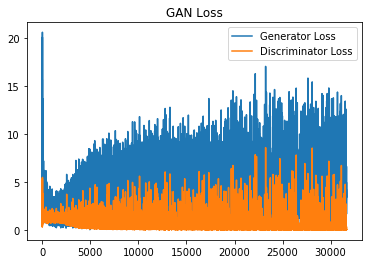

In [14]:
gan_model.fit(X)

We can see that the generator saturates after first few epochs. So it'd be good to train the generator more than 2 times like we've done here. Also making the layers more deep would improve the performance of our GAN model.

## Save the GAN model

Save our GAN model for future use and training.

In [15]:
gan_model.save_weights("models\\face_GAN") 

Saved successfully


## Evaluation

Let's have a look at some of the images generated by our GAN model.

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


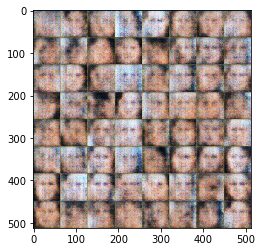

In [16]:
gi = sp.imread('new_samples\\sample100.png')
plt.imshow(gi) 

Image generated during 100th batch, so we can't expect much at the beginning itself.

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


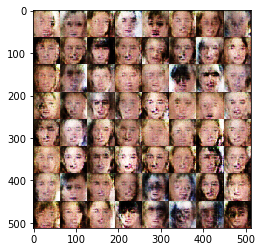

In [17]:
gi = sp.imread('new_samples\\sample500.png')
plt.imshow(gi)

We can clearly see the faces starting to get generated by our GAN.

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


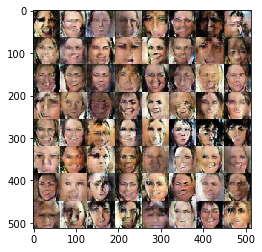

In [18]:
gi = sp.imread('new_samples\\sample1000.png')
plt.imshow(gi)

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


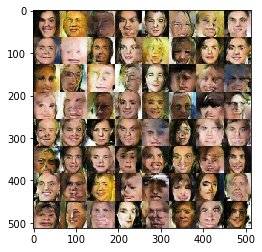

In [19]:
gi = sp.imread('new_samples\\sample2000.png')
plt.imshow(gi)

Fine improvement.

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


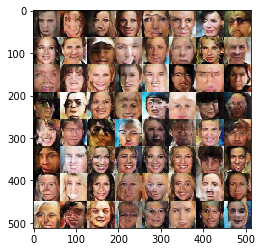

In [20]:
gi = sp.imread('new_samples\\sample5000.png')
plt.imshow(gi)

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


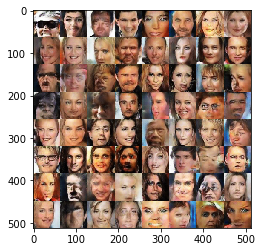

In [21]:
gi = sp.imread('new_samples\\sample15000.png')
plt.imshow(gi)

We can see that the GAN is trying to mix the faces of the celebrities present in the dataset to create a new face.

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


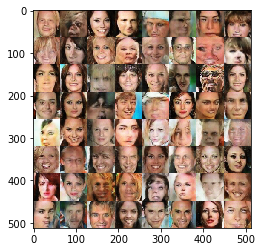

In [22]:
gi = sp.imread('new_samples\\sample25000.png')
plt.imshow(gi) 

The GAN is definitely improving to create good faces.

c:\users\akshay~1\tfobj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


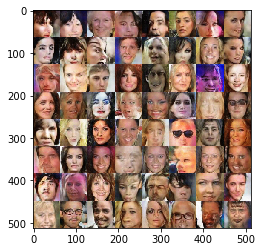

In [23]:
gi = sp.imread('new_samples\\sample31600.png')
plt.imshow(gi)

Not bad for just 10 epochs and not so deep network.

## Conclusion

The DCGAN model was used to produce images of human faces. Will be using this model to generate a single image, apply some image processing techniques over it and produce a final quality image. Will be deploying altogether as a website where a new human face will be generated everytime a person visits the webpage.